# **Market state early detection**

**Author**: Álvaro Villadangos

This is the first notebook of a series of Quant trading. This time you will learn to detect when the market is bullish or bearish by using Gaussian Mixture Models. 

GMM is a clustering unsupervised model very similar to KMeans, but with the advantage that it returns the probability of belonging to each cluster. Also, GMM are used to detect gaussian distributions rather than proximity (Kmeans). In additon, GNN takes into account std in order to assign a cluster for each obs.

# **Market data:** Bitcoin

As an example we will use Bitcoin data to feed the GMM model. This data has the tipical OCHL data of the asset, but also we will add moving averages and RSI.

In [19]:

def rsi(df: pd.DataFrame, periods: int = 14, ema: bool = True) -> pd.DataFrame:
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

## **Feature engineering**

In this case we are working with time series data, but GNN only takes into account the current state. This is why we need to provide some context by doing feature engineering.

- *Close_pct*: Close price percent change.
- *Volume_pct*: Trading volume change.
- *IndicatorEWN*: it is a bool where True means the 100 day EWM is above 10 day EWM.
- *RSI50*: it is the RSI indicator for 50 days.

In [34]:
import pandas as pd

data = pd.read_csv('Market state\BTC-USD.csv')

# Feature engineering
data['Close_pct'] = data['Close'].pct_change()
data['Volume_pct'] = data['Volume'].pct_change()
data['10dayEWM'] = data['Close'].ewm(span=10, adjust=False).mean()
data['100dayEWM'] = data['Close'].ewm(span=100, adjust=False).mean()
data['IndicatorEWM'] = data['10dayEWM'] > data['100dayEWM']
data['RSI50'] = rsi(data, periods = 50)

data.dropna(inplace=True)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_pct,Volume_pct,10dayEWM,100dayEWM,IndicatorEWM,RSI50
2742,2022-03-21,41246.132813,41454.410156,40668.042969,41077.996094,41077.996094,24615543271,-0.004117,0.222954,40787.199384,42887.434402,False,48.356486
2743,2022-03-22,41074.105469,43124.707031,40948.281250,42358.808594,42358.808594,32004652376,0.031180,0.300181,41072.946513,42876.966564,False,49.554528
2744,2022-03-23,42364.378906,42893.507813,41877.507813,42892.957031,42892.957031,25242943069,0.012610,-0.211273,41403.857516,42877.283207,False,50.047659
2745,2022-03-24,42886.652344,44131.855469,42726.164063,43960.933594,43960.933594,31042992291,0.024899,0.229769,41868.780439,42898.741630,False,51.024431
2746,2022-03-25,43958.675781,44982.519531,43711.871094,44395.964844,44395.964844,30379415552,0.009896,-0.021376,42328.268513,42928.389615,False,51.419283


## **Modeling:** Gaussian Mixture models

In a first step, we will reduce the dimensionality to 2 components in order to improve the performance.

In a second step, we will feed the GMM model with the new data and infer 3 clusters. 

Text(0.5, 1.0, 'Kmeans clustering')

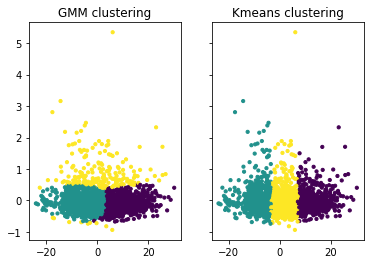

<Figure size 1440x576 with 0 Axes>

In [79]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture


# Dimensionality reduction
pca = PCA(n_components = 2)
Y_sklearn = pca.fit_transform(data[['Close_pct','Volume_pct','IndicatorEWM','RSI50']])

# GMM with 3 componente
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(Y_sklearn)
prediction_gmm = gmm.predict(Y_sklearn)
probs = gmm.predict_proba(Y_sklearn)

# Kmeans with 3 componente
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(Y_sklearn)
prediction_kmeans = kmeans.predict(Y_sklearn)

# Visualize clustering
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=10, cmap='viridis')
ax1.set_title('GMM clustering')
ax2.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_kmeans ,s=10, cmap='viridis')
plt.figure(figsize = (20,8))
ax2.set_title('Kmeans clustering')

In [86]:
# Probabilities and final cluster
out_gnn = pd.DataFrame(probs, columns=['Bull','Bear','Event'])
out_gnn['Cluster'] = prediction_gmm
out_gnn.columns.name = 'GNN'
out_gnn.round(2)

GNN,Bull,Bear,Event,Cluster
0,0.01,0.96,0.02,1
1,0.01,0.96,0.03,1
2,0.08,0.75,0.17,1
3,0.00,0.00,1.00,2
4,0.01,0.92,0.07,1
...,...,...,...,...
2692,0.04,0.90,0.06,1
2693,0.05,0.82,0.12,1
2694,0.12,0.86,0.02,1
2695,0.09,0.83,0.08,1


## **Data viz**: Bull run and bear market state detection

In this viz we can appreciate how the model identified in yellow when the market is bearish, in green when the market is bullish and it looks like the purple obs are critical points in the market (ATH, drastic changes or Lows).

Take into account that we are feeding the model with information about the price change, volume change and 2 technical indicators. So, it is not posible for the model to know the previous or next state.

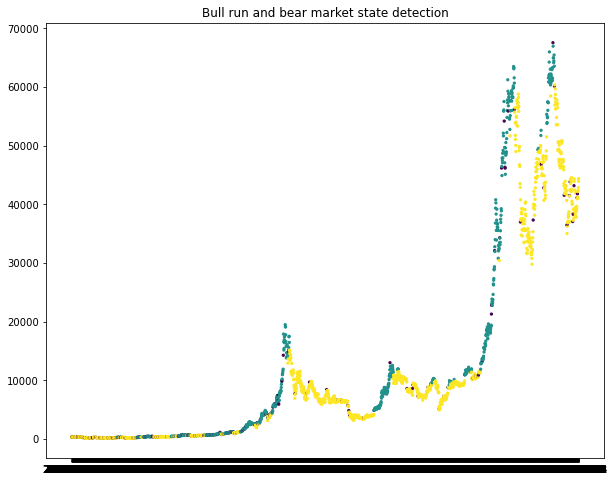

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
plt.scatter(data['Date'], data['Close'], c=prediction_gmm, s=5, cmap='viridis')
#plt.plot(data['Date'], data['100dayEWM'])
#plt.plot(data['Date'], data['10dayEWM'])
plt.title('Bull run and bear market state detection');